In [0]:
import os
import re
import json
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)    
import nltk
from nltk.stem import LancasterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display 
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
!unzip train.zip

In [0]:
with open("train.json", 'r') as f:
    claims = json.load(f)

In [0]:
ARTICLES_DIR = "train_articles"
# extract all file paths
all_files = [pth for pth in Path(ARTICLES_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [0]:
def read_articles(file_list):
  #tokenizer = RegexpTokenizer(r'\w+')
  #word_counter = Counter()
  all_articles = {}
  for file_path in file_list:
      with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        filename = os.path.basename(file_path)
        filename = filename.replace(".txt","")
        file_data = file.read()
        #file_data = tosentences(file_data)
        #file_words = tokenizer.tokenize(file_data)
        #word_counter.update(file_words)
        all_articles[filename] = file_data
  return all_articles

In [0]:
# save all articles in a dictionary
all_articles = read_articles(all_files)

In [0]:
# number of claims
len(claims)

15555

In [0]:
# number of articles
len(all_articles)

64974

In [0]:
# distributino of labels 0, 1, 2
label=[]
for c in claims:
  label.append(c['label'])

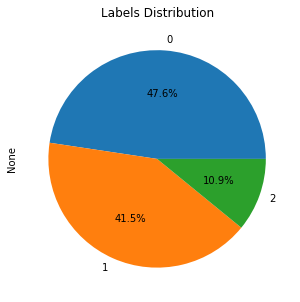

In [0]:
pd.Series(label).value_counts().plot(
    kind='pie', title='Labels Distribution', figsize=(5, 5),autopct='%1.1f%%')
plt.show()

In [0]:
def articleLength(article):
  tokenizer = RegexpTokenizer(r'\w+')  
  article = article.replace("\n"," ").replace("\\","")
  article_words = tokenizer.tokenize(article)
  length = len(article_words)

  return length

In [0]:
# Visualize words count distribution of articles
word_count = []

for i in all_articles.values():
  word_count.append(articleLength(i))

Text(0, 0.5, 'number of articles (Log scale)')

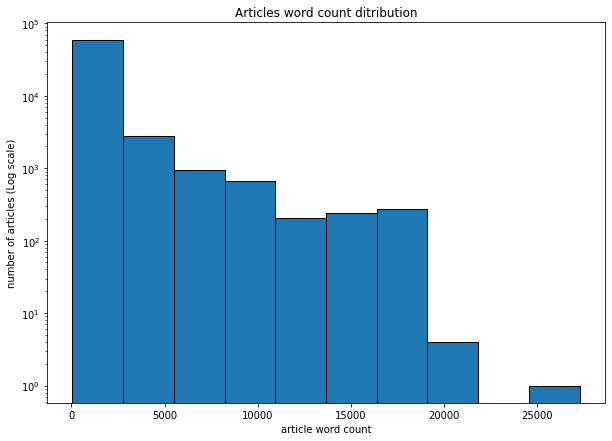

In [0]:
plt.figure(figsize=(10,7))
plt.hist(word_count, edgecolor='black')
plt.yscale("log")
plt.title("Articles word count ditribution")
plt.xlabel("article word count")
plt.ylabel("number of articles (Log scale)")

In [0]:
claims[0]['claim']

"A line from George Orwell's novel 1984 predicts the power of smartphones."

In [0]:
c_length = []
for c in claims:
  c_length.append(articleLength(c['claim']))

Text(0, 0.5, 'frequency (Log scale)')

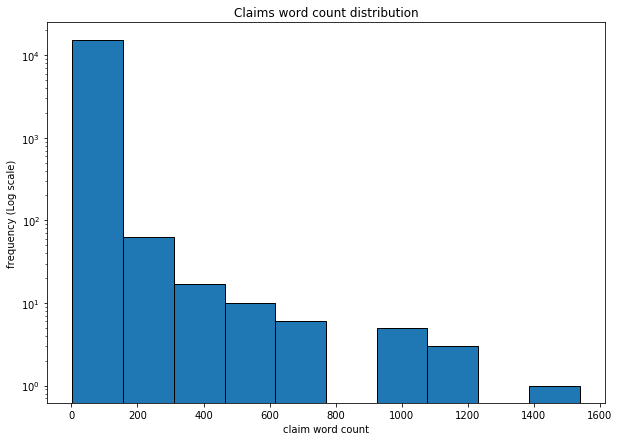

In [0]:
plt.figure(figsize=(10,7))
plt.hist(c_length, edgecolor='black')
plt.yscale("log")
plt.title("Claims word count distribution")
plt.xlabel("claim word count")
plt.ylabel("frequency (Log scale)")

In [0]:
np.corrcoef(x, y).round(3)

array([[ 1.   , -0.019],
       [-0.019,  1.   ]])

Text(0.5, 0, 'length of claims')

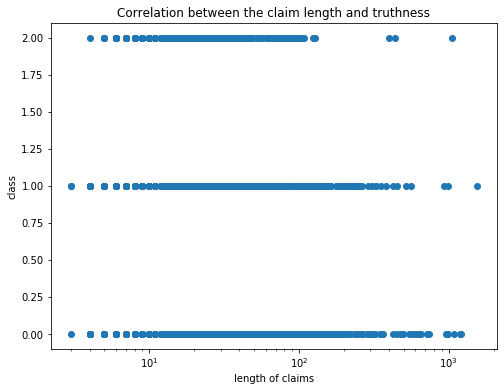

In [0]:
# Correlation btw claims and scales
y = label
x = c_length
fig = plt.figure(figsize=(8,6))
plt.plot(x, y,"o")
plt.title("Correlation between the claim length and truthness")
plt.ylabel('class')
plt.xscale('log')
plt.xlabel('length of claims')

There is negative correlation between length of claim and how true the claim is. The longer the claim, the faker it is.

In [0]:
df_claim=pd.DataFrame.from_dict(claims)
df_claim.head()

,claim,claimant,date,label,related_articles,id
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,"[122094, 122580, 130685, 134765]",0
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,2,"[106868, 127320, 128060]",1
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,1,"[132130, 132132, 149722]",4
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,2,"[123254, 123418, 127464]",5
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6


In [0]:
df_claim[df_claim['label'] == 2].claim

1        Maine legislature candidate Leslie Gibson insu...
3        In 1988 author Roald Dahl penned an open lette...
4        When it comes to fighting terrorism, "Another ...
5        Rhode Island is "almost dead last" among North...
14       "We are always going to need architects, docto...
                               ...                        
15539    A photograph shows a musher riding over snowle...
15544    A photograph shows Donald Trump, Muhammad Ali,...
15545    A photograph shows a man mowing his lawn durin...
15550    The omnibus spending bill has "9,427 pork barr...
15553    As of August 2017, members of the public could...
Name: claim, Length: 1696, dtype: object

In [0]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
#stopwordsList=open('stop_words.txt', 'r').read().split('\n')
stopwords.update(['say',
'says',
'said',
'see',
'state',
'year',
'years',
'percent',
'time',
'example',
'people',
'would',
'one',
'million'])

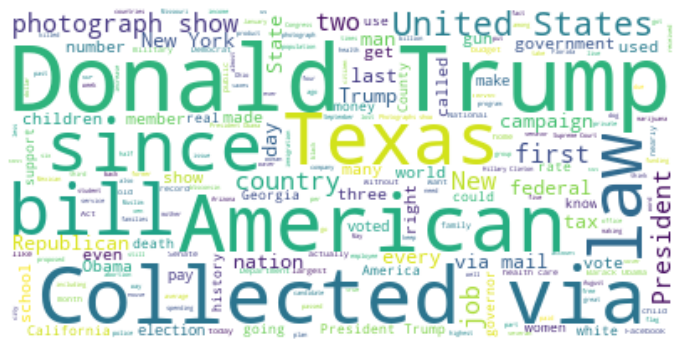

In [0]:
# Wordcloud beautification for True claims
from wordcloud import WordCloud
true_word_tokens = pd.Series(
    df_claim[df_claim['label'] == 2].claim.tolist()).str.cat(sep=' ')
true_word_tokens.lower()
wordcloud = WordCloud(max_font_size=100, stopwords=stopwords, random_state=None, background_color='white').generate(true_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

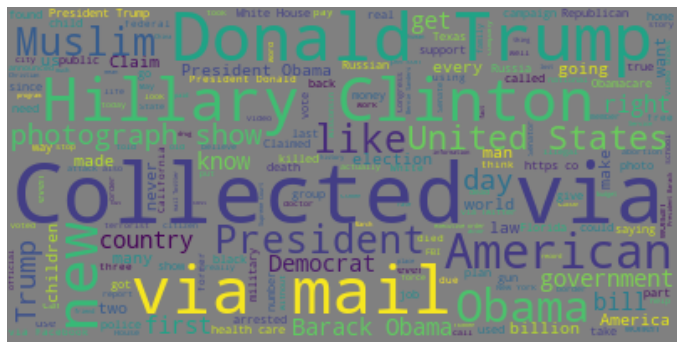

In [0]:

# Wordcloud beautification for Fake news
from wordcloud import WordCloud
true_word_tokens = pd.Series(
    df_claim[df_claim['label'] == 0].claim.tolist()).str.cat(sep=' ')

wordcloud = WordCloud(max_font_size=100, stopwords=stopwords, random_state=None, background_color='grey').generate(true_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

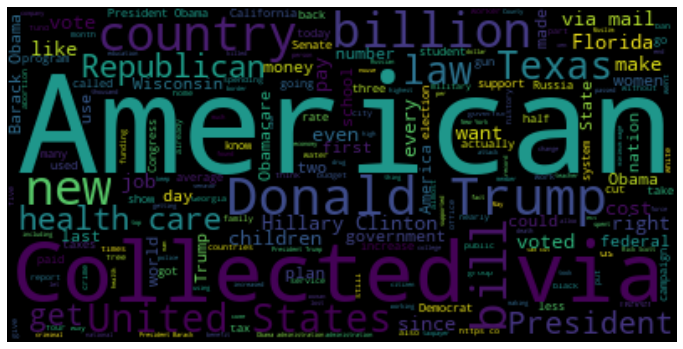

In [0]:
# Wordcloud beautification for partially true news
from wordcloud import WordCloud
true_word_tokens = pd.Series(
    df_claim[df_claim['label'] == 1].claim.tolist()).str.cat(sep=' ')

true_word_tokens.lower()

wordcloud = WordCloud(max_font_size=100, stopwords=stopwords, random_state=None, background_color='black').generate(true_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
beauty='emma sarah  fan: qiqi'

In [0]:
beauty.split(['  ', ':'])

TypeError: ignored